In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
import itertools
import warnings
warnings.filterwarnings('ignore')

In [17]:
df_train= pd.read_csv("train.csv")

In [18]:
df_train_copy= df_train.copy()

In [19]:
df_train.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [20]:
df_train.isnull().values.any()

False

In [21]:
df_train.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [22]:
df_train.shape

(913000, 4)

In [23]:
df_train.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [24]:
df_train.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

In [25]:
df_train.index

RangeIndex(start=0, stop=913000, step=1)

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [27]:
df_train[["store"]].nunique()

store    10
dtype: int64

In [28]:
df_train[["item"]].nunique()

item    50
dtype: int64

In [29]:
df_train[["sales"]].nunique()

sales    213
dtype: int64

In [30]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
store,913000.0,5.500000,2.872283,1.0,3.0,5.5,8.0,10.0
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


In [31]:
df_train.describe([0, 0.05, 0.50, 0.75, 0.95, 0.99, 1]).T

,count,mean,std,min,0%,5%,50%,75%,95%,99%,100%,max
store,913000.0,5.500000,2.872283,1.0,1.0,1.0,5.5,8.0,10.0,10.0,10.0,10.0
item,913000.0,25.500000,14.430878,1.0,1.0,3.0,25.5,38.0,48.0,50.0,50.0,50.0
sales,913000.0,52.250287,28.801144,0.0,0.0,16.0,47.0,70.0,107.0,135.0,231.0,231.0


In [32]:
df_train.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [33]:
df_train.groupby(["store", "item"]).agg({"sales": ["sum"]})

sales
               sum
store item        
1     1      36468
      2      97050
      3      60638
      4      36440
      5      30335
...            ...
10    46    120601
      47     45204
      48    105570
      49     60317
      50    135192

[500 rows x 1 columns]

In [34]:
df_train.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
               sum       mean median        std
store item                                     
1     1      36468  19.971522   19.0   6.741022
      2      97050  53.148959   52.0  15.005779
      3      60638  33.208105   33.0  10.072529
      4      36440  19.956188   20.0   6.640618
      5      30335  16.612815   16.0   5.672102
...            ...        ...    ...        ...
10    46    120601  66.046550   65.0  18.114991
      47     45204  24.755750   24.0   7.924820
      48    105570  57.814896   57.0  15.898538
      49     60317  33.032311   32.0  10.091610
      50    135192  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [35]:
df_train.groupby(["date"]).agg({"sales": ["sum"]})

,sales
,sum
date,
2013-01-01,13696
2013-01-02,13678
2013-01-03,14488
2013-01-04,15677
2013-01-05,16237
...,...
2017-12-27,20378
2017-12-28,21885


In [36]:
df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [37]:
df_train["date"] = pd.to_datetime(df_train["date"])
print('First Date:', df_train['date'].min())
print('Last Date:', df_train['date'].max())

First Date: 2013-01-01 00:00:00
Last Date: 2017-12-31 00:00:00


In [38]:
df_train["Year"] = df_train["date"].apply(lambda x: x.year)
df_train["Month"] = df_train["date"].apply(lambda x: x.month)
df_train["Day"] = df_train["date"].apply(lambda x: x.day)

In [39]:
df_train.head()

,date,store,item,sales,Year,Month,Day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [40]:
df_train.tail()

,date,store,item,sales,Year,Month,Day
912995,2017-12-27,10,50,63,2017,12,27
912996,2017-12-28,10,50,59,2017,12,28
912997,2017-12-29,10,50,74,2017,12,29
912998,2017-12-30,10,50,62,2017,12,30
912999,2017-12-31,10,50,82,2017,12,31


In [41]:
df_train.groupby(["store", "Year", "Month", "Day"]).agg({"sales": ["count","sum", "mean","median","std"]})

sales                               
                     count   sum   mean median        std
store Year Month Day                                     
1     2013 1     1      50  1316  26.32   22.0  12.274812
                 2      50  1264  25.28   26.0  10.796901
                 3      50  1305  26.10   25.0  13.004316
                 4      50  1452  29.04   25.5  13.210942
                 5      50  1499  29.98   30.0  12.667635
...                    ...   ...    ...    ...        ...
10    2017 12    27     50  2221  44.42   44.5  19.158938
                 28     50  2429  48.58   44.5  20.660610
                 29     50  2687  53.74   52.5  24.595346
                 30     50  2742  54.84   54.5  23.921948
                 31     50  2939  58.78   56.5  25.782679

[18260 rows x 5 columns]

In [42]:
#Verileri analiz etmek için mağaza ve ürün verilerini toplayarak tüm mağazaların toplam günlüksatışlarını bulun.

In [43]:
df_train.groupby(["store","date"]).agg({"sales": ["sum"]})

sales
                   sum
store date            
1     2013-01-01  1316
      2013-01-02  1264
      2013-01-03  1305
      2013-01-04  1452
      2013-01-05  1499
...                ...
10    2017-12-27  2221
      2017-12-28  2429
      2017-12-29  2687
      2017-12-30  2742
      2017-12-31  2939

[18260 rows x 1 columns]

In [44]:
#Günlük satışlardan aylık satışlara kadar bir aggregation işlemi yapın. Tahmini bu verilere göre yapın.

In [45]:
df_train.groupby(["Month", "date"]).agg({"sales": ["sum"]})

sales
                    sum
Month date             
1     2013-01-01  13696
      2013-01-02  13678
      2013-01-03  14488
      2013-01-04  15677
      2013-01-05  16237
...                 ...
12    2017-12-27  20378
      2017-12-28  21885
      2017-12-29  23535
      2017-12-30  24988
      2017-12-31  26420

[1826 rows x 1 columns]

In [46]:
#aylık satışlar
df_train["day"] = "01"
df_train["new_date"] = df_train.Year.astype(str) + "-" + df_train.Month.astype(str) + "-" + df_train.Day.astype(str)

In [47]:
df_train.drop('Day', inplace=True, axis=1)

In [48]:
df_train.head()

,date,store,item,sales,Year,Month,day,new_date
0,2013-01-01,1,1,13,2013,1,01,2013-1-1
1,2013-01-02,1,1,11,2013,1,01,2013-1-2
2,2013-01-03,1,1,14,2013,1,01,2013-1-3
3,2013-01-04,1,1,13,2013,1,01,2013-1-4
4,2013-01-05,1,1,10,2013,1,01,2013-1-5


In [49]:
df_train.tail()

,date,store,item,sales,Year,Month,day,new_date
912995,2017-12-27,10,50,63,2017,12,01,2017-12-27
912996,2017-12-28,10,50,59,2017,12,01,2017-12-28
912997,2017-12-29,10,50,74,2017,12,01,2017-12-29
912998,2017-12-30,10,50,62,2017,12,01,2017-12-30
912999,2017-12-31,10,50,82,2017,12,01,2017-12-31


In [50]:
df_new = df_train.groupby(["new_date","store"]).agg({"sales": "sum"}).reset_index()
df_new = df_new.set_index("new_date")
df_new=df_new[df_new["store"]==2]
df_new = df_new.drop('store', axis=1)
df_new

,sales
new_date,
2013-1-1,1742
2013-1-10,1956
2013-1-11,1989
2013-1-12,2166
2013-1-13,2258
...,...
2017-9-5,3603
2017-9-6,3750
2017-9-7,3869


In [51]:
#Satış verilerini kullanarak şirketin sonraki 3 aylık satış tahminini yapın. (Train .csv ve Test.csv)

In [52]:
df_train

,date,store,item,sales,Year,Month,day,new_date
0,2013-01-01,1,1,13,2013,1,01,2013-1-1
1,2013-01-02,1,1,11,2013,1,01,2013-1-2
2,2013-01-03,1,1,14,2013,1,01,2013-1-3
3,2013-01-04,1,1,13,2013,1,01,2013-1-4
4,2013-01-05,1,1,10,2013,1,01,2013-1-5
...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12,01,2017-12-27
912996,2017-12-28,10,50,59,2017,12,01,2017-12-28
912997,2017-12-29,10,50,74,2017,12,01,2017-12-29
912998,2017-12-30,10,50,62,2017,12,01,2017-12-30


In [53]:
dff=df_train.groupby(["date"]).agg({"sales": ["sum"]})
dff

,sales
,sum
date,
2013-01-01,13696
2013-01-02,13678
2013-01-03,14488
2013-01-04,15677
2013-01-05,16237
...,...
2017-12-27,20378
2017-12-28,21885


In [54]:
df_train.groupby(["Month"]).agg({"sales": ["sum"]})

,sales
,sum
Month,
1,2753149
2,2776177
3,3666182
4,4136467
5,4582437
6,4726911
7,5192393
8,4580655


In [55]:
df_train.groupby(["Year","Month"]).agg({"sales": ["sum"]})

sales
                sum
Year Month         
2013 1       454904
     2       459417
     3       617382
     4       682274
     5       763242
     6       795597
     7       855922
     8       766761
     9       689907
     10      656587
     11      692643
     12      506607
2014 1       525987
     2       529117
     3       704301
     4       788914
     5       882877
     6       906842
     7       989010
     8       885596
     9       785124
     10      758883
     11      800783
     12      578048
2015 1       552513
     2       551317
     3       730951
     4       824467
     5       926902
     6       937184
     7      1037350
     8       920401
     9       823332
     10      797253
     11      827645
     12      607572
2016 1       602439
     2       614957
     3       790881
     4       901950
     5       988730
     6      1022664
     7      1138718
     8       981494
     9       896831
     10      863637
     11      891448
     12      663411
2017 1       617306
     2       621369
     3       822667
     4       938862
     5      1020686
     6      1064624
     7      1171393
     8      1026403
     9       935263
     10      891160
     11      928837
     12      695170

In [56]:
dff

,sales
,sum
date,
2013-01-01,13696
2013-01-02,13678
2013-01-03,14488
2013-01-04,15677
2013-01-05,16237
...,...
2017-12-27,20378
2017-12-28,21885


In [57]:
df_train

,date,store,item,sales,Year,Month,day,new_date
0,2013-01-01,1,1,13,2013,1,01,2013-1-1
1,2013-01-02,1,1,11,2013,1,01,2013-1-2
2,2013-01-03,1,1,14,2013,1,01,2013-1-3
3,2013-01-04,1,1,13,2013,1,01,2013-1-4
4,2013-01-05,1,1,10,2013,1,01,2013-1-5
...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12,01,2017-12-27
912996,2017-12-28,10,50,59,2017,12,01,2017-12-28
912997,2017-12-29,10,50,74,2017,12,01,2017-12-29
912998,2017-12-30,10,50,62,2017,12,01,2017-12-30


In [58]:
df_train.groupby(["new_date"]).agg({"sales": ["sum"]})

,sales
,sum
new_date,
2013-1-1,13696
2013-1-10,14642
2013-1-11,15633
2013-1-12,16679
2013-1-13,17741
...,...
2017-9-5,28289
2017-9-6,28568


In [59]:
df_train["new_date"]= pd.to_datetime(df_train[["Year","Month","day"]])

In [60]:
df_train.head()

,date,store,item,sales,Year,Month,day,new_date
0,2013-01-01,1,1,13,2013,1,01,2013-01-01
1,2013-01-02,1,1,11,2013,1,01,2013-01-01
2,2013-01-03,1,1,14,2013,1,01,2013-01-01
3,2013-01-04,1,1,13,2013,1,01,2013-01-01
4,2013-01-05,1,1,10,2013,1,01,2013-01-01


In [61]:
df=df_train.groupby("new_date").agg({"sales":"sum"})

In [62]:
df.head()

,sales
new_date,
2013-01-01,454904
2013-02-01,459417
2013-03-01,617382
2013-04-01,682274
2013-05-01,763242


In [63]:
df.isnull().any()

sales    False
dtype: bool

In [64]:
def ts_decompose(y, model="additive", stationary=False):
    y = df.copy()
    model = "additive"
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)


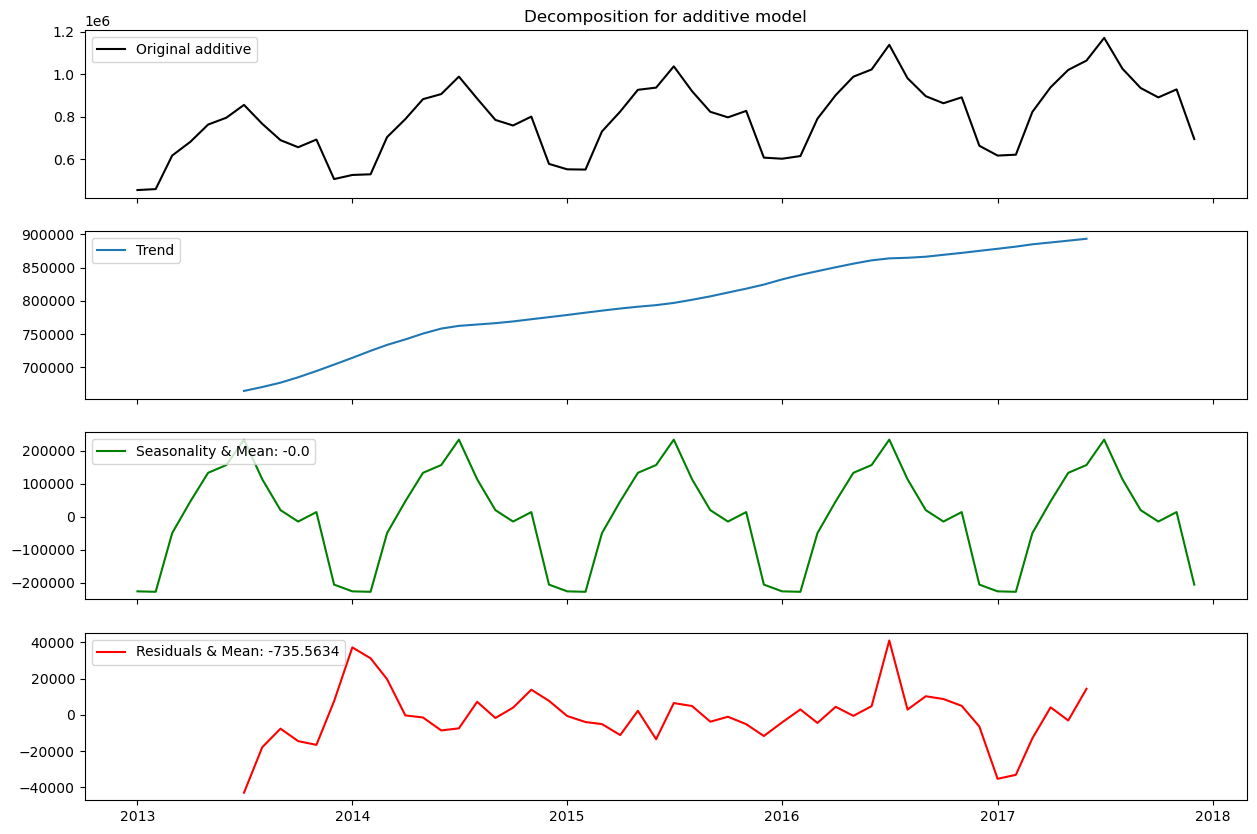

In [65]:
for model in["additive"]:
    ts_decompose(df, model)

In [66]:
#df=df.reset_index()

In [67]:
df.head()

,sales
new_date,
2013-01-01,454904
2013-02-01,459417
2013-03-01,617382
2013-04-01,682274
2013-05-01,763242


In [68]:
df= df.reset_index()
analysis_date = pd.to_datetime("1 January 2017")

train = df[df["new_date"] < analysis_date]
test = df[df["new_date"] >= analysis_date]
test = test.iloc[:12, :]
train = train.set_index("new_date")
test = test.set_index("new_date")

In [69]:
print(train.tail())
print(test.head())

             sales
new_date          
2016-08-01  981494
2016-09-01  896831
2016-10-01  863637
2016-11-01  891448
2016-12-01  663411
              sales
new_date           
2017-01-01   617306
2017-02-01   621369
2017-03-01   822667
2017-04-01   938862
2017-05-01  1020686


In [70]:
alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

In [71]:
best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
step = 12

In [72]:
train

,sales
new_date,
2013-01-01,454904
2013-02-01,459417
2013-03-01,617382
2013-04-01,682274
2013-05-01,763242
2013-06-01,795597
2013-07-01,855922
2013-08-01,766761
2013-09-01,689907


In [73]:
for comb in abg:
    tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
        fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
    
    y_pred = tes_model.forecast(step)
    
    mae = mean_absolute_error(test, y_pred)
    
    if mae < best_mae:
        best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
    
    
    print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

[0.1, 0.1, 0.1, 29806.58]
[0.1, 0.1, 0.3, 30769.78]
[0.1, 0.1, 0.5, 32085.2]
[0.1, 0.1, 0.7, 33998.31]
[0.1, 0.1, 0.9, 36273.18]
[0.1, 0.3, 0.1, 47127.46]
[0.1, 0.3, 0.3, 51716.53]
[0.1, 0.3, 0.5, 51024.18]
[0.1, 0.3, 0.7, 46148.97]
[0.1, 0.3, 0.9, 40949.68]
[0.1, 0.5, 0.1, 73037.04]
[0.1, 0.5, 0.3, 64057.31]
[0.1, 0.5, 0.5, 44553.62]
[0.1, 0.5, 0.7, 23672.92]
[0.1, 0.5, 0.9, 23190.79]
[0.1, 0.7, 0.1, 53237.39]
[0.1, 0.7, 0.3, 32046.58]
[0.1, 0.7, 0.5, 20944.5]
[0.1, 0.7, 0.7, 24625.13]
[0.1, 0.7, 0.9, 22468.48]
[0.1, 0.9, 0.1, 26376.68]
[0.1, 0.9, 0.3, 19967.95]
[0.1, 0.9, 0.5, 17023.72]
[0.1, 0.9, 0.7, 18874.31]
[0.1, 0.9, 0.9, 16593.55]
[0.3, 0.1, 0.1, 30539.89]
[0.3, 0.1, 0.3, 31905.9]
[0.3, 0.1, 0.5, 33489.72]
[0.3, 0.1, 0.7, 32647.79]
[0.3, 0.1, 0.9, 29525.97]
[0.3, 0.3, 0.1, 22801.43]
[0.3, 0.3, 0.3, 25826.63]
[0.3, 0.3, 0.5, 29512.82]
[0.3, 0.3, 0.7, 29015.9]
[0.3, 0.3, 0.9, 26403.28]
[0.3, 0.5, 0.1, 38531.12]
[0.3, 0.5, 0.3, 30384.01]
[0.3, 0.5, 0.5, 23575.24]
[0.3, 0.5, 0.7, 

In [74]:
print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
      "best_mae:", round(best_mae, 4))

best_alpha: 0.1 best_beta: 0.9 best_gamma: 0.9 best_mae: 16593.5533


In [77]:
def plot_prediction(y_pred, label):
    train["Ham"].plot(legend=True, label="TRAIN")
    test["Ham"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

In [78]:
tes_model_monthly = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

In [79]:
y_pred_monthly = tes_model_monthly.forecast(12)
mean_absolute_error(test, y_pred_monthly)

16593.55325474324

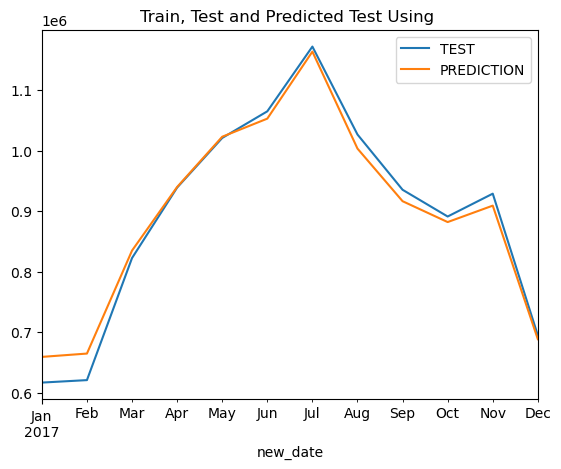

In [82]:
test["sales"].plot(legend=True, label="TEST")
y_pred_monthly.plot(legend=True, label="PREDICTION")
plt.title("Train, Test and Predicted Test Using ")
plt.show()

In [83]:
test

,sales
new_date,
2017-01-01,617306
2017-02-01,621369
2017-03-01,822667
2017-04-01,938862
2017-05-01,1020686
2017-06-01,1064624
2017-07-01,1171393
2017-08-01,1026403
2017-09-01,935263


In [84]:
y_pred_monthly

2017-01-01    6.596609e+05
2017-02-01    6.651530e+05
2017-03-01    8.349744e+05
2017-04-01    9.398463e+05
2017-05-01    1.022710e+06
2017-06-01    1.052577e+06
2017-07-01    1.163079e+06
2017-08-01    1.003177e+06
2017-09-01    9.164148e+05
2017-10-01    8.820010e+05
2017-11-01    9.091056e+05
2017-12-01    6.888273e+05
Freq: MS, dtype: float64

In [85]:
# Ocak-Şubat
test_ocak_subat = test.iloc[:2,:]
pred_ocak_subat = y_pred_monthly.iloc[:2]

# Mart-Haziran
test_mart_haziran = test.iloc[2:6,:]
pred_mart_haziran = y_pred_monthly.iloc[2:6]


# Temmuz-Aralık
test_temmuz_aralik = test.iloc[6:12,:]
pred_temmuz_aralik = y_pred_monthly.iloc[6:12]

In [86]:
# Ocak-Şubat
print("mae:", mean_absolute_error(test_ocak_subat, pred_ocak_subat))
print("mean percent error", (mean_absolute_error(test_ocak_subat, pred_ocak_subat) / test_ocak_subat.mean().values[0]) * 100)

mae: 43069.4104723208
mean percent error 6.954109911368326


In [87]:
# Mart-Haziran
print("mae:", mean_absolute_error(test_mart_haziran, pred_mart_haziran))
print("mean percent error", (mean_absolute_error(test_mart_haziran, pred_mart_haziran) / test_mart_haziran.mean().values[0]) * 100)

mae: 6840.700969548605
mean percent error 0.7113061887485912


In [88]:
# Temmuz-Aralık
print("mae:", mean_absolute_error(test_temmuz_aralik, pred_temmuz_aralik))
print("mean percent error", (mean_absolute_error(test_temmuz_aralik, pred_temmuz_aralik) / test_temmuz_aralik.mean().values[0]) * 100)

mae: 14270.169039013816
mean percent error 1.5158921444376143
